<a href="https://colab.research.google.com/github/sg2083/independent_study/blob/main/Sentiment_analysis_08_04_wip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis of Stock-Related News & Posts and Predicting Stock Market Prices

### Introduction
The stock market is highly influenced by investor sentiment, which is often reflected in news articles, social media discussions, and online forums. This study focuses on analyzing the sentiment of stock-related posts from multiple sources, including Reddit, NewsAPI, and historical stock prices.

The goal is to determine whether online sentiment correlates with stock price movements and if it can be used as a predictive feature for stock performance.

## Research Questions
1. Does investor sentiment expressed in Reddit posts and news articles correlate with stock price movements for Tesla?
2. Can sentiment data extracted from online platforms be used to predict stock price trends in the short term?
3. What is the relative significance of different sentiment sources (Reddit vs. NewsAPI) in predicting stock market performance?
4. How does sentiment change in response to major news events, and does this sentiment shift correlate with subsequent stock price movements?

##Hypotheses
>**H1**:There is a significant positive correlation between positive sentiment in Reddit posts/news articles and an increase in Tesla's stock price.<br>
**H2**: Negative sentiment in Reddit posts/news articles is significantly correlated with a decrease in Tesla's stock price.<br>
**H3**: Sentiment data from Reddit is more predictive of short-term stock price fluctuations than sentiment data from news articles.<br>
**H4**: Major news events (e.g., product launches, regulatory announcements) cause a significant shift in sentiment, which is reflected in short-term stock price movements.

## Literature Review
The study by Nti, Adekoya, and Weyori (2020) investigates how public sentiment, derived from web news, Twitter, Google Trends, and forum discussions, influences stock market predictions. Using sentiment analysis with an Artificial Neural Network (ANN) model, the authors predict stock prices on the Ghana Stock Exchange (GSE) over time frames of 1 to 90 days. They find that combining multiple data sources improves prediction accuracy, with the highest accuracy (70.66–77.12%) achieved from a combined dataset. The study highlights a strong link between stock market behavior and social media, suggesting that sentiment data from online platforms can help investors predict future stock price movements and make better investment decisions.
link: https://sciendo.com/article/10.2478/acss-2020-0004

## How its different from whats already been done
Event-Driven Sentiment Evolution and Its Impact on Stock Price Prediction

### Data
The data for this study is collected from three primary sources: **Reddit, NewsAPI, and stock market data**. Reddit posts related to **Tesla** stock are retrieved using praw library from financial discussion subreddits like r/wallstreetbets, capturing post titles and timestamps. News articles mentioning Tesla are obtained via NewsAPI, extracting headlines, publication dates, and sources. Historical stock price data is being sourced from Yahoo Finance api, including daily open, high, low, close prices, trading volume, and other financial indicators.

Since these datasets originate from different platforms, they contain varying timestamp formats, time zones, and missing values, requiring careful preprocessing and merging to align sentiment data with stock price movements for further analysis.

### Data Preprocessing
The collected data is being cleaned and standardized before merging. Steps include:

1. Date Format Standardization

  * Convert timestamps from different time zones to UTC
  * Convert stock market timestamps (which include hours/minutes) to date-only format

2. Column Renaming for Clarity

  * Title → title_reddit (for Reddit)
  * Title → title_news (for NewsAPI)
  
  This prevents column name conflicts

3. Handling Missing Data

  * Some dates lack both Reddit posts and news articles
  * Missing values must be carefully handled to avoid bias

4. Merging Data

  Outer join used to keep all records from Reddit, NewsAPI, and stock price data Ensures no loss of important data points Note: Since data comes from multiple sources, preprocessing is still in progress to handle scattered and missing data.

#### Initial Approach:

Using average_sentiment as sentiment source: Calculated using the *VADER* sentiment analyzer from stock-related news headlines.

Features Used:
- Independent Variable: average_sentiment
- Target Variable: Close (Tesla stock price)

#### Observations:

- *LSTM* and *XGBoost* struggled to capture meaningful trends with only average_sentiment.
- Random Forest performed the best among all, indicating non-linear relationships.
- The raw average_sentiment showed low correlation with Close price (r = 0.12) and the models struggled to capture stock trends with such noisy day-to-day sentiment data.


#### Improving Features Using Moving Averages

Stock prices are generally influenced by trends rather than daily sentiment fluctuations, so decided to calculate moving averages of sentiment (5, 10, 30 days) to capture sustained market sentiment.

>Hypothesis: Smoothed sentiment (over days or weeks) might better reflect overall market sentiment and drive stock price movements.

- Computed moving averages using Pandas .rolling().mean() on average_sentiment.
- sentiment_ma_30 showed the highest correlation with stock prices (0.52), indicating better potential as a predictive feature.

#### Observations of moving averages:
- Random Forest Regression delivered high accuracy with the smoothed sentiment (R² = 0.93), showing its robustness.
- LSTM models saw dramatic improvements when Close price was added alongside sentiment_ma_30.
- Tuned XGBoost has still underperformed here, but improved when compared to the previous XGBoost results.

#### Takeaways:
- Moving average of sentiment is significantly more effective than using raw daily scores.

- Among all models, *Random Forest* gave the best results with sentiment_ma_30.

- LSTM with combined features (sentiment_ma_30 + Close) showed strong predictive power.

- This approach supports the hypothesis that smoothed sentiment reflects investor sentiment more realistically, thereby better predicting stock movements.

In [ ]:
# @title Importing required libraries
!pip install newsapi-python
!pip install praw
!pip install finnhub-python

import yfinance as yf
from newsapi import NewsApiClient
import praw
from datetime import datetime
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.api as sm
from wordcloud import WordCloud
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler, RobustScaler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 3.4 MB/s eta 0:00:00


In [ ]:
# @title Fetching stock history data for Tesla stocks
tesla = yf.Ticker("TSLA")
tesla_data = tesla.history(period="1y")
print(tesla_data.head())

                                 Open        High         Low       Close  \
Date                                                                        
2024-04-09 00:00:00-04:00  172.910004  179.220001  171.919998  176.880005   
2024-04-10 00:00:00-04:00  173.039993  174.929993  170.009995  171.759995   
2024-04-11 00:00:00-04:00  172.550003  175.880005  168.509995  174.600006   
2024-04-12 00:00:00-04:00  172.339996  173.809998  170.360001  171.050003   
2024-04-15 00:00:00-04:00  170.240005  170.690002  161.380005  161.479996   

                              Volume  Dividends  Stock Splits  
Date                                                           
2024-04-09 00:00:00-04:00  103232700        0.0           0.0  
2024-04-10 00:00:00-04:00   84532400        0.0           0.0  
2024-04-11 00:00:00-04:00   94516000        0.0           0.0  
2024-04-12 00:00:00-04:00   64506600        0.0           0.0  
2024-04-15 00:00:00-04:00  100245300        0.0           0.0  


In [ ]:
# Save tesla_data to a CSV file
tesla_data.to_csv('tesla_data.csv')

# Read the CSV file back into a DataFrame named tesla_data
tesla_data = pd.read_csv('tesla_data.csv')
print(tesla_data.head())


                        Date        Open        High         Low       Close  \
0  2024-04-09 00:00:00-04:00  172.910004  179.220001  171.919998  176.880005   
1  2024-04-10 00:00:00-04:00  173.039993  174.929993  170.009995  171.759995   
2  2024-04-11 00:00:00-04:00  172.550003  175.880005  168.509995  174.600006   
3  2024-04-12 00:00:00-04:00  172.339996  173.809998  170.360001  171.050003   
4  2024-04-15 00:00:00-04:00  170.240005  170.690002  161.380005  161.479996   

      Volume  Dividends  Stock Splits  
0  103232700        0.0           0.0  
1   84532400        0.0           0.0  
2   94516000        0.0           0.0  
3   64506600        0.0           0.0  
4  100245300        0.0           0.0  


In [ ]:
# Convert the 'Date' column to datetime objects
tesla_data['Date'] = pd.to_datetime(tesla_data['Date'], utc=True)

# Format the 'Date' column to 'YYYY-mm-dd'
tesla_data['Date'] = tesla_data['Date'].dt.strftime('%Y-%m-%d')

print(tesla_data.head())

tesla_data.to_csv('tesla_data.csv', index=False)

         Date        Open        High         Low       Close     Volume  \
0  2024-04-09  172.910004  179.220001  171.919998  176.880005  103232700   
1  2024-04-10  173.039993  174.929993  170.009995  171.759995   84532400   
2  2024-04-11  172.550003  175.880005  168.509995  174.600006   94516000   
3  2024-04-12  172.339996  173.809998  170.360001  171.050003   64506600   
4  2024-04-15  170.240005  170.690002  161.380005  161.479996  100245300   

   Dividends  Stock Splits  
0        0.0           0.0  
1        0.0           0.0  
2        0.0           0.0  
3        0.0           0.0  
4        0.0           0.0  


In [ ]:
# # import tweepy

# # # Replace with your API keys
# # api_key = "QJDjqRmClnqkLg7nmNQ2gg9Qc"
# # api_secret = "kzuVz5zut9BdrbUML9w3upnwkW7mmFWe7iLUnxdsiBRU10w3ec"
# # access_token = "1268163737153728512-Qr5jw5gZ6mz2ZbN4QW3pq5kxw5JAi7"
# # access_secret = "qQ5WVKhmj3XX17WQxMfoJEzgAqwFxwz8qdYEsS3IaL69a"
# # bearer_token = "AAAAAAAAAAAAAAAAAAAAAMMezAEAAAAAtN2XctoVzTlyEi8YhnI6%2FEeIRUM%3Dx7uIiCT3lQMTLkCSJkAGPBVIqawsEkrH4qXPlWJNOC2JYupBwa"

# # # Authenticate
# # client = tweepy.Client(bearer_token=bearer_token)

# from tweepy import OAuthHandler
# from tweepy import API

# consumer_key = 'YFUHQYil2JuiR4ws600kN2yD2'
# consumer_secret = '0x6LEfbpBz0Rnvm3dBw7lFAeygUTFcDaNU4YjN6eUMTFHLoUP9'
# access_token = '1889172540888948736-jrvTNNgPQHvEfE5OAyaaCBBfx2xpWR'
# access_token_secret = 'dK2tcEBm1nEBxZoGAiZw2TgnDZUhHyfMuYzVGrlorekeN'
# # Consumer key authentication
# auth = OAuthHandler(consumer_key, consumer_secret)

# # Access key authentication
# auth.set_access_token(access_token, access_token_secret)

# # Set up the API with the authentication handler
# api = API(auth)

In [ ]:
# import tweepy
# import csv
# import datetime

# # Twitter API credentials
# bearer_token = 'AAAAAAAAAAAAAAAAAAAAAFw2zAEAAAAABxOmWd%2BogWMxVgvfWVX3Lrsy8T4%3D9QG2pYsqHFgF2XkzGbC7oiIALJNQGE13bI9uv60b0i5oPJWWdo'  # Bearer Token for API v2

# # Authenticate to the Twitter API
# client = tweepy.Client(bearer_token=bearer_token)

# # Define the query and date range for historic tweets
# query = 'Tesla'
# # Use 'since' and 'until' as parameters to filter for tweets within the past 7 days
# max_tweets = 10  # Limit to 10 tweets

# # Create a function to collect the tweets
# def collect_tweets(query, max_tweets=10):
#     tweets = []
#     # Using search_recent_tweets for recent tweets (within the past 7 days)
#     for tweet in tweepy.Paginator(client.search_recent_tweets,  # Using search_recent_tweets for free access
#                                   query=query,
#                                   tweet_fields=['created_at', 'author_id', 'text'],
#                                   max_results=10).flatten(limit=max_tweets):  # Limit to 10 tweets
#         tweets.append([tweet.created_at, tweet.author_id, tweet.text])

#     return tweets

# # Collect the tweets
# tweets = collect_tweets(query, max_tweets)

# # Save the tweets to a CSV file
# with open('tesla_tweets.csv', 'w', newline='', encoding='utf-8') as file:
#     writer = csv.writer(file)
#     writer.writerow(["Date", "User ID", "Tweet"])
#     writer.writerows(tweets)

# print(f"Collected {len(tweets)} tweets about Tesla.")



In [ ]:
# query = "(Tesla OR TSLA OR Tesla stock OR Tesla shares) -is:retweet lang:en"

# # # Fetch recent tweets (last 7 days)
# # tweets = client.search_recent_tweets(query=query, max_results=5, tweet_fields=["created_at", "text"])

# # # Store in DataFrame & Save
# # data = [[tweet.created_at, tweet.text] for tweet in tweets.data]
# # df = pd.DataFrame(data, columns=["timestamp", "tweet"])
# # df.to_csv("stock_tweets.csv", index=False)

# # print("Saved tweets to stock_tweets.csv!")
# import requests

# url = "https://api.twitter.com/2/tweets/search/recent"

# params = {
#     "query": "Tesla OR TSLA OR Tesla stock -is:retweet lang:en",
#     "max_results": 10,
#     "tweet.fields": "created_at,text"
# }

# # API headers
# headers = {"Authorization": f"Bearer {bearer_token}"}

# # Make request
# response = requests.get(url, headers=headers, params=params)

# # Check response status
# if response.status_code == 200:
#     tweets = response.json()
#     for tweet in tweets["data"]:
#         print(f"{tweet['created_at']}: {tweet['text']}\n")
# else:
#     print(f"Error {response.status_code}: {response.text}")

In [ ]:
# newsapi returns only the past 30 days data
# from datetime import datetime, timedelta
# from dateutil.relativedelta import relativedelta
# import time

# # Initialize NewsAPI client
# newsapi = NewsApiClient(api_key="3c53572d3893466a8240a9916ff53acb")

# # Define the date range
# end_date = datetime(2025, 3, 11).date()
# start_date = end_date - timedelta(days=30)

# # File to store the news data
# csv_filename = "tesla_news_data.csv"

# # Iterate through each day in the range
# for i in range(31):  # Including the end date
#     current_date = start_date + timedelta(days=i)
#     current_date_str = current_date.strftime("%Y-%m-%d")

#     print(f"Fetching news for {current_date_str}...")

#     try:
#         # Fetch news for the specific day
#         articles = newsapi.get_everything(q="Tesla stock", language="en",
#                                           from_param=current_date_str,
#                                           to=current_date_str,
#                                           page_size=100)

#         # Extract relevant data
#         news_data = []
#         for article in articles.get("articles", []):
#             news_data.append({
#                 'Date': article['publishedAt'],
#                 'Title': article['title'],
#                 'Description': article['description']
#             })

#         # Append data to CSV
#         df = pd.DataFrame(news_data)
#         df.to_csv(csv_filename, mode='a', header=not pd.io.common.file_exists(csv_filename), index=False)

#         print(f"Saved {len(news_data)} articles for {current_date_str}.")

#         time.sleep(2)

#     except Exception as e:
#         print(f"Error fetching news for {current_date_str}: {e}")


In [ ]:
# import tabulate

# reddit = praw.Reddit(
#     client_id="AHwBapk4BbgYfXKt4SSpAw",
#     client_secret="_iiyfM51ZSRzzFtwYV3zqBxbbj7fqw",
#     user_agent="StockSentimentAnalysis"
# )

# # Define subreddits to search
# subreddits = ["wallstreetbets", "stocks"]
# query = "Tesla stock"
# limit = 250  # Fetch more posts since we filter manually

# # Get timestamps for the last 1 month
# current_date = datetime.utcnow()
# one_month_back = current_date - relativedelta(months=12)
# one_month_back_timestamp = int(one_month_back.timestamp())

# # Store results
# results = []

# for subreddit_name in subreddits:
#     subreddit = reddit.subreddit(subreddit_name)
#     posts = subreddit.search(query, sort="new", limit=limit)  # Get recent posts

#     for post in posts:
#         # Only keep posts from the last 1 month
#         if post.created_utc >= one_month_back_timestamp:
#             results.append({
#                 "Subreddit": subreddit_name,
#                 "Date": datetime.utcfromtimestamp(post.created_utc).strftime('%Y-%m-%d'),
#                 "Title": post.title,
#                 "Score": post.score,
#                 "Comments": post.num_comments,
#                 "URL": post.url
#             })

# # Display results in a readable table
# if results:
#     # print(tabulate.tabulate(results, headers="keys", tablefmt="grid"))
#     print(len(results))
# results_df = pd.DataFrame(results)
# results_df

In [ ]:
# # !pip install GoogleNews

# # !pip install GoogleNews
# from GoogleNews import GoogleNews

# # Initialize GoogleNews
# googlenews = GoogleNews()
# googlenews.set_time_range('03/11/2024', '04/11/2024')  # MM/DD/YYYY format

# # Search for Tesla stock news
# googlenews.get_news('Tesla')

# # Fetch results
# news_results = googlenews.result()
# print(f"Total articles found: {len(news_results)}")


# news_results
# # news_results_pd = pd.DataFrame(news_results)
# # news_results_pd

# # # Print first few articles
# # for news in news_results[:5]:  # Limit output
# #     print(f"Title: {news['title']}\nDate: {news['date']}\nSource: {news['media']}\nURL: {news['link']}\n")


# from GoogleNews import GoogleNews

# # Initialize GoogleNews
# googlenews = GoogleNews()

# # Set date range (MM/DD/YYYY) - Extend end date to ensure inclusion
# start_date = '03/11/2024'
# end_date = '03/11/2025'  # Extending by 1 day to include March 10

# googlenews.set_time_range(start_date, end_date)

# # Search for stock-related Tesla news
# query = 'Tesla'
# googlenews.get_news(query)

# # Fetch all pages of results
# all_results = []
# page = 1

# while True:
#     results = googlenews.result()

#     if not results:  # Stop if no more results
#         break

#     all_results.extend(results)  # Store results

#     print(f"Fetched Page {page}, Total Articles: {len(all_results)}")

#     googlenews.clear()  # Clear previous page data
#     googlenews.search(query)  # Re-run search for pagination

#     page += 1

# # Print total articles retrieved
# print(f"\nTotal articles retrieved: {len(all_results)}")

# all_results
# # Display first 5 articles
# for news in all_results[:5]:
#     print(f"Title: {news['title']}\nDate: {news['date']}\nSource: {news['media']}\nURL: {news['link']}\n")
# all_results_pd = pd.DataFrame(all_results)
# all_results
# merged_file_path = "google_results.csv"
# all_results_pd.to_csv(merged_file_path, index=False)

In [ ]:
# this code was used to fetch past year finnhub news data from 11th March,2025

# from datetime import datetime, timedelta
# import pandas as pd
# import finnhub
# import time  # To avoid rate limits

# # Initialize Finnhub client
# finnhub_client = finnhub.Client(api_key="cuuush9r01qpi6rsa3hgcuuush9r01qpi6rsa3i0")

# # Define the date range
# end_date = datetime(2025, 3, 11).date()
# start_date = end_date - timedelta(days=365)

# # File to store the news data
# csv_filename = "tesla_finn_news.csv"

# # Iterate through each day in the range
# for i in range(366):  # Including the end date
#     current_date = start_date + timedelta(days=i)
#     current_date_str = current_date.strftime("%Y-%m-%d")

#     print(f"Fetching news for {current_date_str}...")

#     try:
#         # Fetch news from Finnhub
#         finn_data = finnhub_client.company_news('TSLA', _from=current_date_str, to=current_date_str)

#         # Convert UNIX timestamp to standard date format
#         for article in finn_data:
#             article['datetime'] = datetime.fromtimestamp(article['datetime']).strftime('%Y-%m-%d')

#         # Append daily data to CSV
#         df = pd.DataFrame(finn_data)
#         df.to_csv(csv_filename, mode='a', header=not pd.io.common.file_exists(csv_filename), index=False)

#         print(f"Saved {len(finn_data)} articles for {current_date_str}.")

#         # To avoid api rate limiting
#         time.sleep(2)

#     except Exception as e:
#         print(f"Error fetching news for {current_date_str}: {e}")


In [ ]:
# to update the tesla_finn_news csv file with the latest data
# from datetime import datetime, timedelta
# import pandas as pd
# import finnhub
# import time
# import os

# # Initialize Finnhub client
# finnhub_client = finnhub.Client(api_key="cuuush9r01qpi6rsa3hgcuuush9r01qpi6rsa3i0")

# # Define date range
# start_date = datetime(2025, 6, 1).date()
# end_date = datetime.today().date()

# # File to store news data
# csv_filename = "tesla_finn_news.csv"

# # Load existing data if available
# if os.path.exists(csv_filename):
#     existing_df = pd.read_csv(csv_filename)
# else:
#     existing_df = pd.DataFrame()

# # Iterate through each day from the last fetched date to today
# new_data = []
# for i in range((end_date - start_date).days + 1):
#     current_date = start_date + timedelta(days=i)
#     current_date_str = current_date.strftime("%Y-%m-%d")

#     print(f"Fetching news for {current_date_str}...")

#     try:
#         # Fetch news from Finnhub
#         finn_data = finnhub_client.company_news('TSLA', _from=current_date_str, to=current_date_str)

#         # Convert UNIX timestamp to standard date format
#         for article in finn_data:
#             article['datetime'] = datetime.fromtimestamp(article['datetime']).strftime('%Y-%m-%d')

#         # Append to list
#         new_data.extend(finn_data)

#         print(f"Fetched {len(finn_data)} articles for {current_date_str}.")

#         # Avoid API rate limiting
#         time.sleep(2)

#     except Exception as e:
#         print(f"Error fetching news for {current_date_str}: {e}")

# # Convert new data to DataFrame
# new_df = pd.DataFrame(new_data)

# # Preprocess news data
# if not new_df.empty:
#     new_df = new_df[['datetime', 'headline', 'summary', 'id', 'source', 'url']]
#     new_df.dropna(subset=['headline', 'summary'], inplace=True)
#     new_df['datetime'] = pd.to_datetime(new_df['datetime']).dt.strftime('%Y-%m-%d')

# # Combine and remove duplicates
# if not existing_df.empty:
#     combined_df = pd.concat([existing_df, new_df]).drop_duplicates(subset=['id'], keep='first')
# else:
#     combined_df = new_df

# # Save updated data
# combined_df.to_csv(csv_filename, index=False)
# print("Updated news data saved successfully.")


In [ ]:
# prompt: read tesla_finn_news.csv and store it as a dataframe named "tesla_finn_news"
!wget https://raw.githubusercontent.com/sg2083/independent_study/refs/heads/main/tesla_finn_news.csv -O tesla_finn_news.csv
tesla_finn_news = pd.read_csv('tesla_finn_news.csv')


--2025-04-08 22:26:28--  https://raw.githubusercontent.com/sg2083/independent_study/refs/heads/main/tesla_finn_news.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6704145 (6.4M) [text/plain]
Saving to: ‘tesla_finn_news.csv’

tesla_finn_news.csv 100%[===================>]   6.39M  --.-KB/s    in 0.1s    

2025-04-08 22:26:28 (65.4 MB/s) - ‘tesla_finn_news.csv’ saved [6704145/6704145]



In [ ]:
print(tesla_finn_news.columns)
print(tesla_data.columns)

Index(['category', 'datetime', 'headline', 'id', 'image', 'related', 'source',
       'summary', 'url'],
      dtype='object')
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits'],
      dtype='object')


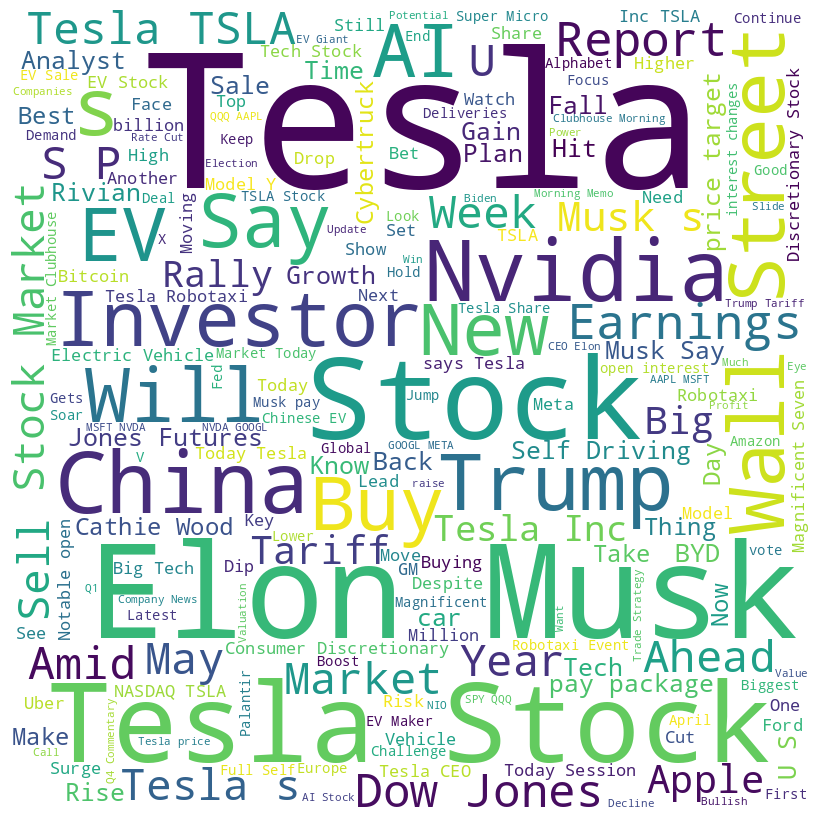

In [ ]:
text = " ".join(review for review in tesla_finn_news.headline.astype(str))

# Create and generate a word cloud image:
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      min_font_size=10).generate(text)

# Display the generated image:
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


--2025-04-08 22:26:34--  https://raw.githubusercontent.com/sg2083/independent_study/refs/heads/main/multiTimeline.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 811 [text/plain]
Saving to: ‘multiTimeline.csv’

multiTimeline.csv   100%[===================>]     811  --.-KB/s    in 0s      

2025-04-08 22:26:35 (56.2 MB/s) - ‘multiTimeline.csv’ saved [811/811]



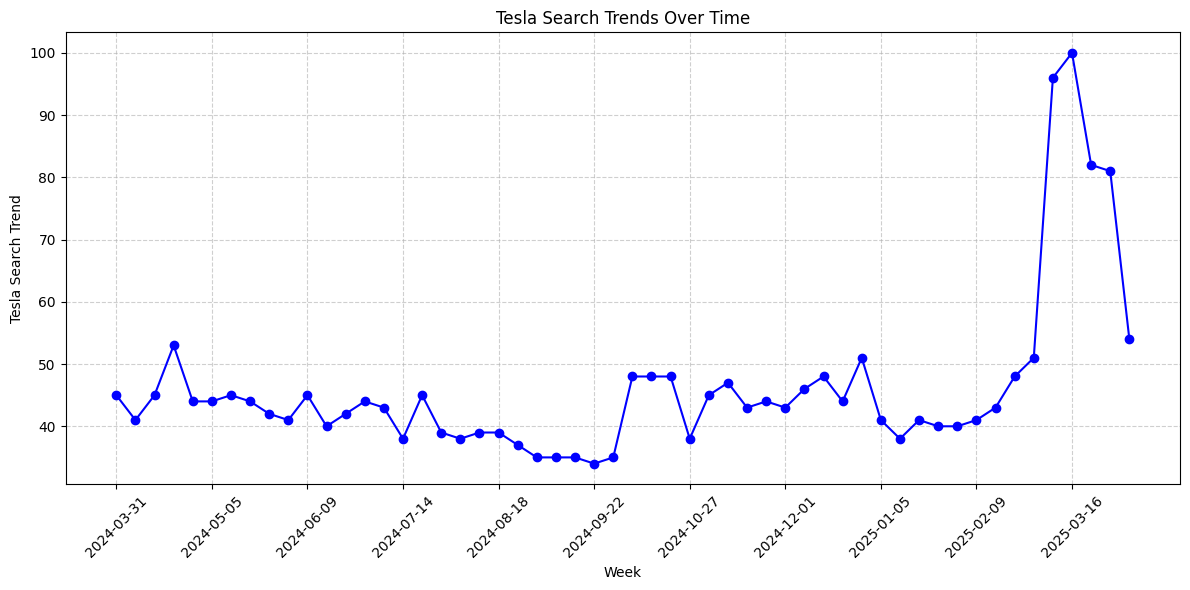

In [ ]:
# Load dataset
!wget https://raw.githubusercontent.com/sg2083/independent_study/refs/heads/main/multiTimeline.csv -O multiTimeline.csv
df = pd.read_csv('multiTimeline.csv', skiprows=2)

# Convert 'Week' column to datetime format
df['Week'] = pd.to_datetime(df['Week'])

# Plot
plt.figure(figsize=(12, 6))  # Adjust figure size

plt.plot(df['Week'], df['tesla: (United States)'], color='blue', marker='o', linestyle='-')

# Improve x-axis labels
plt.xticks(df['Week'][::len(df)//10].dt.strftime('%Y-%m-%d'), rotation=45)

# Labels and title
plt.xlabel('Week')
plt.ylabel('Tesla Search Trend')
plt.title('Tesla Search Trends Over Time')

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Improve layout
plt.tight_layout()

# Show plot
plt.show()


In [ ]:
# Download VADER Lexicon
nltk.download('vader_lexicon')

# Load the processed news data
csv_filename = "tesla_finn_news.csv"
news_df = pd.read_csv(csv_filename)

# Ensure datetime column is in the correct format
news_df['datetime'] = pd.to_datetime(news_df['datetime']).dt.strftime('%Y-%m-%d')

# Initialize Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']

# Apply sentiment analysis using only headlines
news_df['headline_sentiment'] = news_df['headline'].apply(get_sentiment)
news_df['final_sentiment'] = news_df['headline_sentiment']

# Save updated data
news_df.to_csv("tesla_finn_news_sentiment.csv", index=False)
print("Sentiment analysis (headline only) completed and saved successfully.")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Sentiment analysis (headline only) completed and saved successfully.


In [ ]:
# Load the processed news data with sentiment scores
csv_filename = "tesla_finn_news_sentiment.csv"
news_df = pd.read_csv(csv_filename)

# Ensure datetime column is in the correct format
news_df['datetime'] = pd.to_datetime(news_df['datetime']).dt.strftime('%Y-%m-%d')

# Aggregate sentiment scores per day
aggregated_sentiment = news_df.groupby('datetime')['final_sentiment'].mean().reset_index()
aggregated_sentiment.rename(columns={'datetime': 'Date', 'final_sentiment': 'average_sentiment'}, inplace=True)

# Save the aggregated sentiment data
aggregated_csv_filename = "tesla_aggregated_sentiment.csv"
aggregated_sentiment.to_csv(aggregated_csv_filename, index=False)

print("Aggregated sentiment scores per day saved successfully.")

Aggregated sentiment scores per day saved successfully.


In [ ]:
# Load the aggregated sentiment data
sentiment_filename = "tesla_aggregated_sentiment.csv"
sentiment_df = pd.read_csv(sentiment_filename)

# Load the Tesla stock data
tesla_stock_filename = "tesla_data.csv"
tesla_df = pd.read_csv(tesla_stock_filename)

# Ensure date columns are in the correct format
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])
tesla_df['Date'] = pd.to_datetime(tesla_df['Date'])

# Merge sentiment data with Tesla stock data on 'Date'
merged_df = pd.merge(tesla_df, sentiment_df, on='Date', how='left')

# Save the merged dataset
merged_csv_filename = "tesla_sentiment_stock.csv"
merged_df.to_csv(merged_csv_filename, index=False)

print("Merged sentiment data with Tesla stock prices successfully saved.")


Merged sentiment data with Tesla stock prices successfully saved.


In [ ]:
print(merged_df.head(5))

        Date        Open        High         Low       Close     Volume  \
0 2024-04-09  172.910004  179.220001  171.919998  176.880005  103232700   
1 2024-04-10  173.039993  174.929993  170.009995  171.759995   84532400   
2 2024-04-11  172.550003  175.880005  168.509995  174.600006   94516000   
3 2024-04-12  172.339996  173.809998  170.360001  171.050003   64506600   
4 2024-04-15  170.240005  170.690002  161.380005  161.479996  100245300   

   Dividends  Stock Splits  average_sentiment  
0        0.0           0.0           0.012223  
1        0.0           0.0           0.045186  
2        0.0           0.0           0.057774  
3        0.0           0.0           0.016178  
4        0.0           0.0          -0.057678  


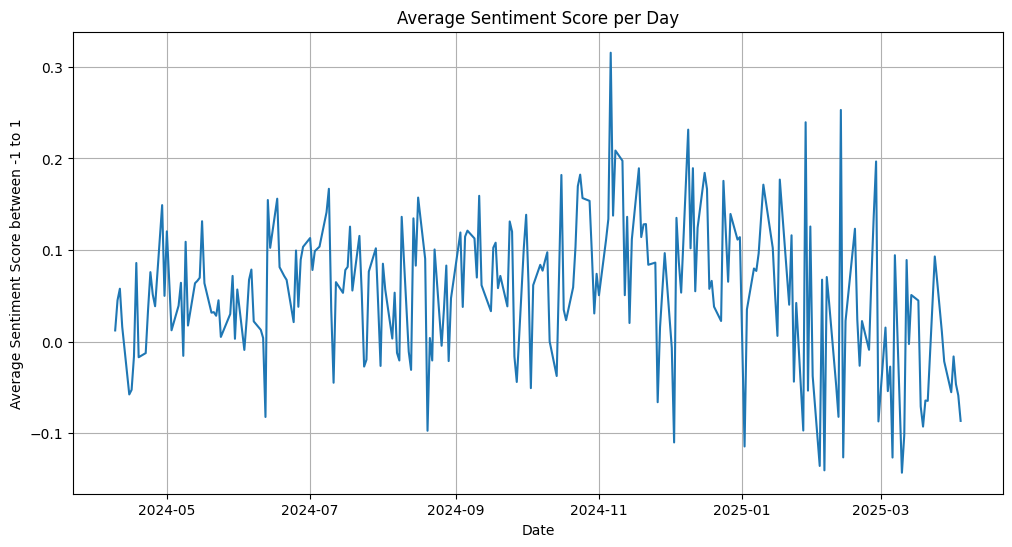

In [ ]:
# prompt: plot average sentiment score per day from merged_df

import matplotlib.pyplot as plt

# Load the merged data
merged_df = pd.read_csv("tesla_sentiment_stock.csv")
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Group by date and calculate average sentiment
average_sentiment_per_day = merged_df.groupby('Date')['average_sentiment'].mean()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(average_sentiment_per_day.index, average_sentiment_per_day.values)
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score between -1 to 1')
plt.title('Average Sentiment Score per Day')
plt.grid(True)
plt.show()


<ipython-input-23-c1349c501560>:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sentiment_counts = sentiment_df.groupby('sentiment_group')['average_sentiment'].count()


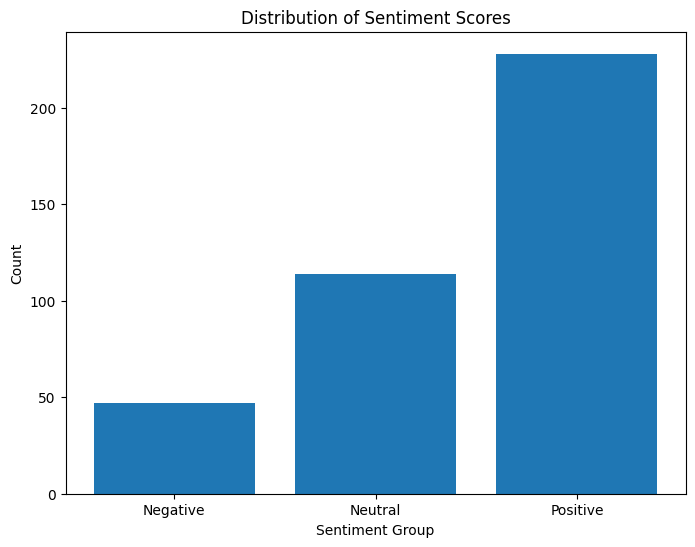

In [ ]:
# Load the aggregated sentiment data
sentiment_filename = "tesla_aggregated_sentiment.csv"
sentiment_df = pd.read_csv(sentiment_filename)

# Define bins for sentiment groups
bins = [-1, -0.05, 0.05, 1]
labels = ['Negative', 'Neutral', 'Positive']

# Categorize sentiment scores into groups
sentiment_df['sentiment_group'] = pd.cut(sentiment_df['average_sentiment'], bins=bins, labels=labels, include_lowest=True)

# Group by sentiment group and count occurrences
sentiment_counts = sentiment_df.groupby('sentiment_group')['average_sentiment'].count()

# Plot bar graph
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Sentiment Group')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Scores')
plt.show()


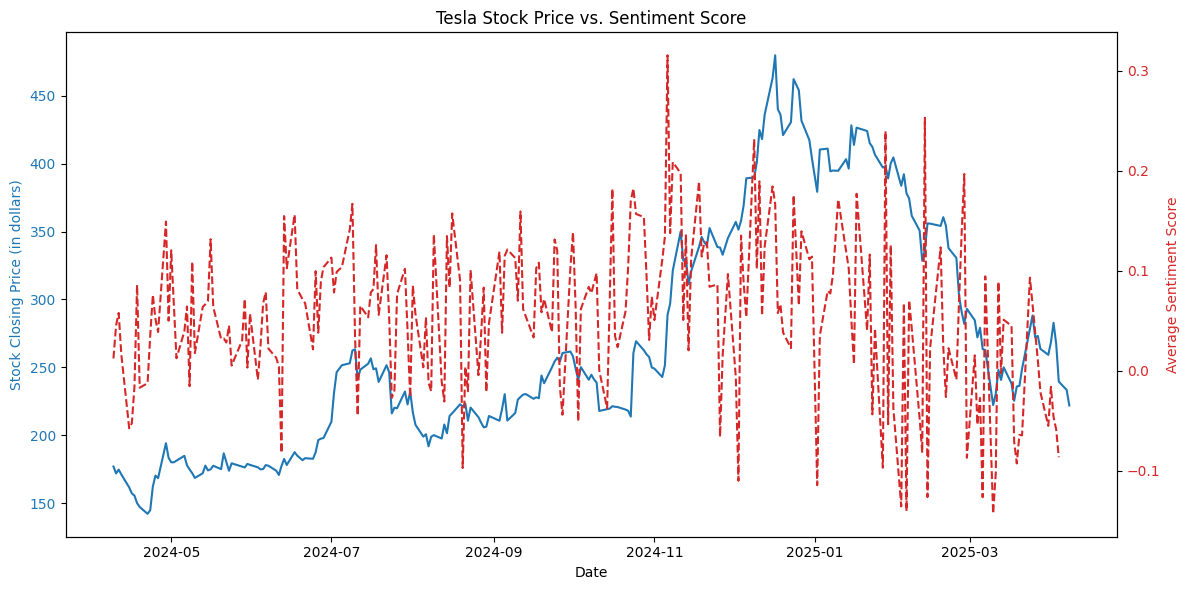

In [ ]:
# Ensure 'Date' is in datetime format
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Sort by Date
merged_df.sort_values(by='Date', inplace=True)

# Plot sentiment vs. closing price
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot stock closing price
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Closing Price (in dollars)', color='tab:blue')
ax1.plot(merged_df['Date'], merged_df['Close'], color='tab:blue', label='Close Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create second y-axis for sentiment score
ax2 = ax1.twinx()
ax2.set_ylabel('Average Sentiment Score', color='tab:red')
ax2.plot(merged_df['Date'], merged_df['average_sentiment'], color='tab:red', linestyle='dashed', label='Sentiment Score')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add title and legend
plt.title("Tesla Stock Price vs. Sentiment Score")
fig.tight_layout()
plt.show()


In [ ]:
merged_df['sentiment_ma_5'] = merged_df['average_sentiment'].rolling(window=5).mean()
merged_df['sentiment_ma_10'] = merged_df['average_sentiment'].rolling(window=10).mean()
merged_df['sentiment_ma_30'] = merged_df['average_sentiment'].rolling(window=30).mean()

merged_df.dropna(subset=['sentiment_ma_5', 'sentiment_ma_10', 'sentiment_ma_30'], inplace=True)

In [ ]:
merged_df.head(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,average_sentiment,sentiment_ma_5,sentiment_ma_10,sentiment_ma_30
29,2024-05-20,177.559998,177.750000,173.520004,174.949997,61727400,0.0,0.0,0.031630,0.072625,0.060229,0.043411
30,2024-05-21,175.509995,186.880005,174.710007,186.600006,115266500,0.0,0.0,0.032214,0.065790,0.057023,0.044078
31,2024-05-22,182.850006,183.800003,178.119995,180.110001,88313500,0.0,0.0,0.028248,0.057489,0.061401,0.043513
32,2024-05-23,181.800003,181.899994,173.259995,173.740005,71975500,0.0,0.0,0.045156,0.040222,0.055012,0.043093
33,2024-05-24,174.839996,180.080002,173.729996,179.240005,65479700,0.0,0.0,0.005139,0.028477,0.053767,0.042725


In [ ]:
# Calculate summary statistics for sentiment columns
sentiment_columns = ['average_sentiment', 'sentiment_ma_5', 'sentiment_ma_10', 'sentiment_ma_30']
sentiment_stats = merged_df[sentiment_columns].describe()
print("Summary Statistics for Sentiment Columns:\n", sentiment_stats)

# Calculate summary statistics for stock prices (e.g., 'Close' price)
stock_close_price_stats = merged_df['Close'].describe()
print("\nSummary Statistics for Stock Prices:\n", stock_close_price_stats)

# Correlation between sentiment columns and closing price
correlation = merged_df[sentiment_columns + ['Close']].corr()
print("\nCorrelation between sentiment columns and Closing price:\n", correlation['Close'].sort_values(ascending=False))

Summary Statistics for Sentiment Columns:
        average_sentiment  sentiment_ma_5  sentiment_ma_10  sentiment_ma_30
count         220.000000      220.000000       220.000000       220.000000
mean            0.056251        0.057603         0.058578         0.061273
std             0.080317        0.047054         0.038990         0.028052
min            -0.143159       -0.060928        -0.035550        -0.007436
25%             0.004862        0.031533         0.035815         0.045615
50%             0.062752        0.058080         0.059136         0.062026
75%             0.108746        0.084923         0.083110         0.077613
max             0.315510        0.198659         0.150175         0.118075

Summary Statistics for Stock Prices:
 count    220.000000
mean     278.668182
std       80.485893
min      170.660004
25%      219.082504
50%      250.760002
75%      345.370003
max      479.859985
Name: Close, dtype: float64

Correlation between sentiment columns and Closing pric

#### Observations from Correlation b/w sentiment columns and Closing Price

- The 30-day moving average of sentiment (`sentiment_ma_30`) has the strongest linear relationship with Tesla's stock price.

- This suggests that longer-term sentiment trends align more closely with price movement than short-term or raw daily sentiment.

- The raw average_sentiment has the weakest correlation.

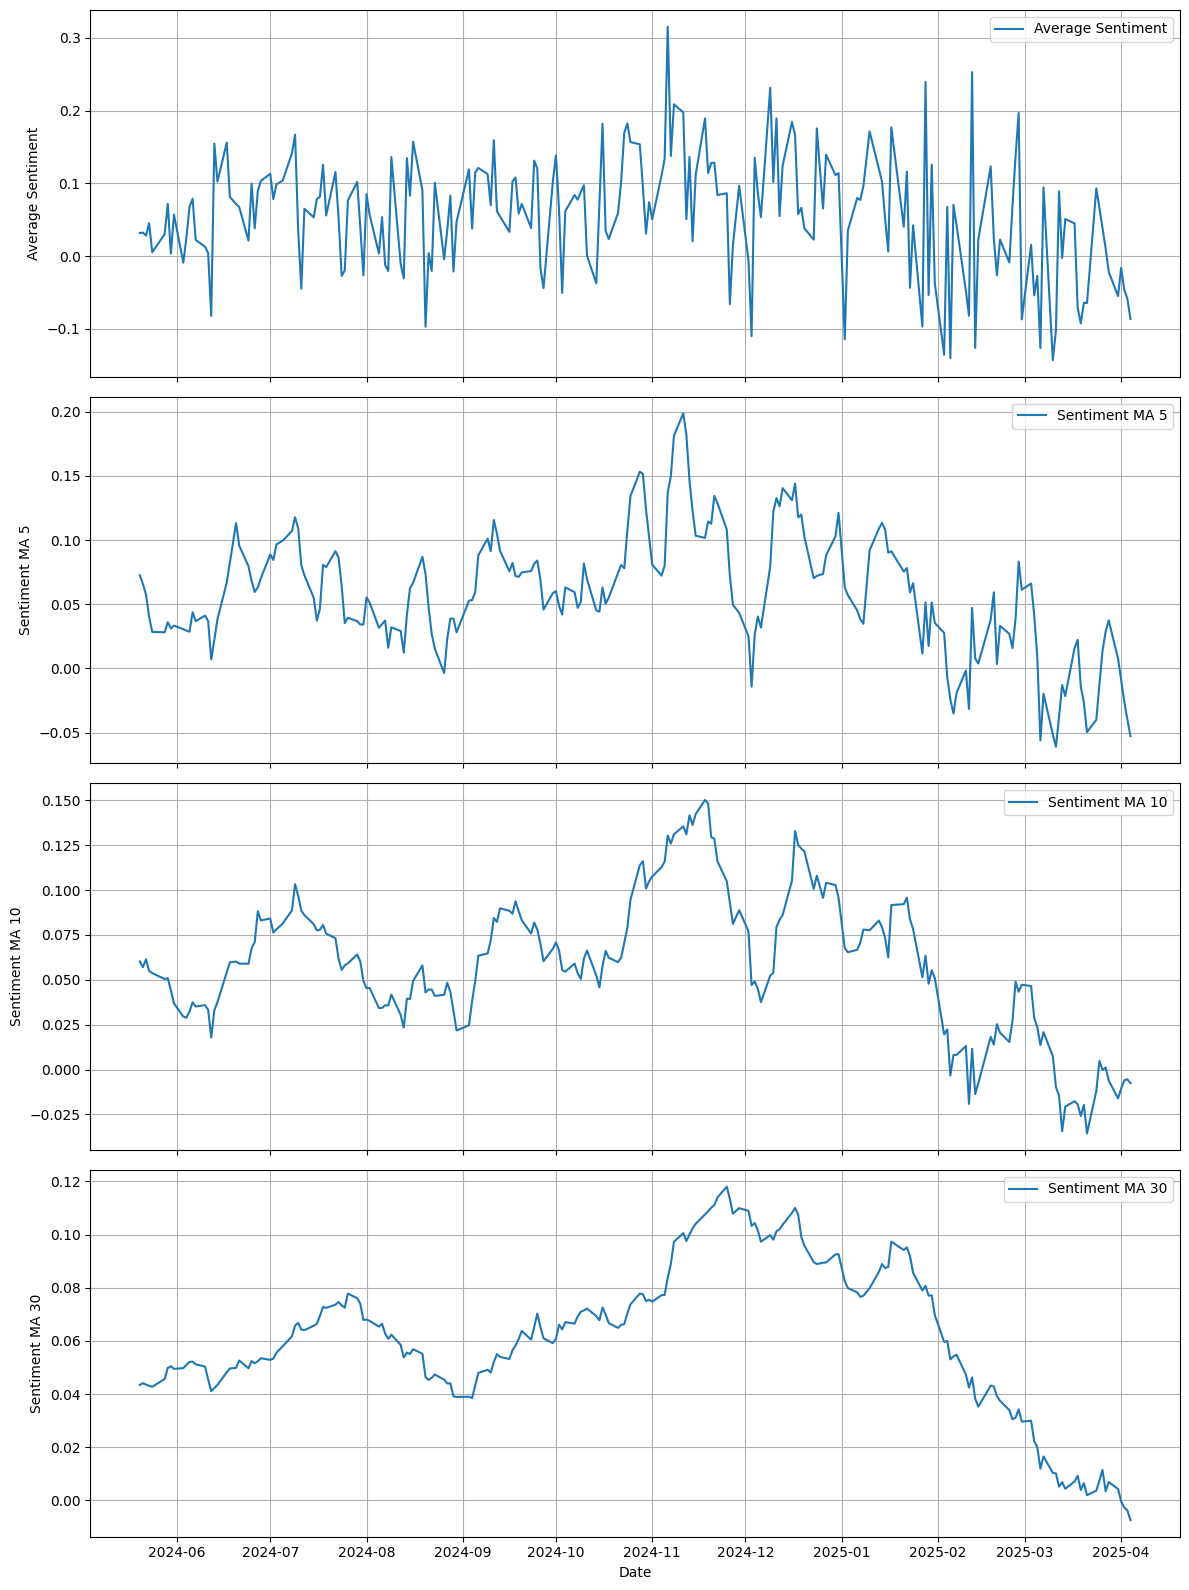

In [ ]:
# prompt: plot sentiment_ma_5, sentiment_ma_10, sentiment_ma_30 along with average_sentiment
# plot should be one below the other separately

import matplotlib.pyplot as plt

# Assuming 'merged_df' is already loaded and processed as in your provided code

# Create subplots for each sentiment metric
fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

# Plot average_sentiment
axes[0].plot(merged_df['Date'], merged_df['average_sentiment'], label='Average Sentiment')
axes[0].set_ylabel('Average Sentiment')
axes[0].legend()
axes[0].grid(True)

# Plot sentiment_ma_5
axes[1].plot(merged_df['Date'], merged_df['sentiment_ma_5'], label='Sentiment MA 5')
axes[1].set_ylabel('Sentiment MA 5')
axes[1].legend()
axes[1].grid(True)

# Plot sentiment_ma_10
axes[2].plot(merged_df['Date'], merged_df['sentiment_ma_10'], label='Sentiment MA 10')
axes[2].set_ylabel('Sentiment MA 10')
axes[2].legend()
axes[2].grid(True)


# Plot sentiment_ma_30
axes[3].plot(merged_df['Date'], merged_df['sentiment_ma_30'], label='Sentiment MA 30')
axes[3].set_ylabel('Sentiment MA 30')
axes[3].set_xlabel('Date') # X-axis label for the bottom plot
axes[3].legend()
axes[3].grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [ ]:
# updating tesla_sentiment_stock file
merged_df.to_csv("tesla_sentiment_stock.csv", index=False)
print(merged_df.head())


         Date        Open        High         Low       Close     Volume  \
29 2024-05-20  177.559998  177.750000  173.520004  174.949997   61727400   
30 2024-05-21  175.509995  186.880005  174.710007  186.600006  115266500   
31 2024-05-22  182.850006  183.800003  178.119995  180.110001   88313500   
32 2024-05-23  181.800003  181.899994  173.259995  173.740005   71975500   
33 2024-05-24  174.839996  180.080002  173.729996  179.240005   65479700   

    Dividends  Stock Splits  average_sentiment  sentiment_ma_5  \
29        0.0           0.0           0.031630        0.072625   
30        0.0           0.0           0.032214        0.065790   
31        0.0           0.0           0.028248        0.057489   
32        0.0           0.0           0.045156        0.040222   
33        0.0           0.0           0.005139        0.028477   

    sentiment_ma_10  sentiment_ma_30  
29         0.060229         0.043411  
30         0.057023         0.044078  
31         0.061401         0

#### Understanding the relationship between Sentiment Scores and stock prices
Ordinary Least Squares (OLS) regression is used to study the relationship between a dependent variable (Tesla’s stock price) and an independent variable (sentiment score). It finds the best-fitting line by minimizing the differences between actual and predicted values.

For this analysis, I used OLS to see if sentiment data (from news) can help predict Tesla’s stock price.

Before applying OLS, I calculated the Pearson correlation coefficient to check if there is a relationship between sentiment and stock price.

KeyError: 'sentiment_ma__30'

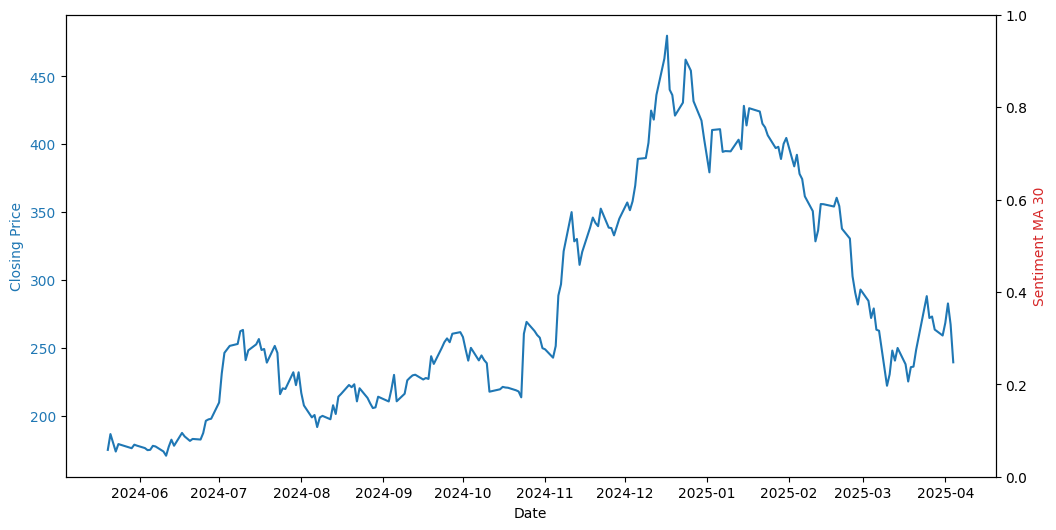

In [ ]:
# # Load the merged data
# merged_df = pd.read_csv("tesla_sentiment_stock.csv")
# merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot stock closing price on the first y-axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Closing Price', color=color)
ax1.plot(merged_df['Date'], merged_df['Close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for sentiment
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Sentiment MA 30', color=color)
ax2.plot(merged_df['Date'], merged_df['sentiment_ma__30'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Add title and show the plot
plt.title('Tesla Stock Price vs. Sentiment MA 30')
fig.tight_layout()
plt.show()


Pearson Correlation: 0.1276, P-value: 0.0589


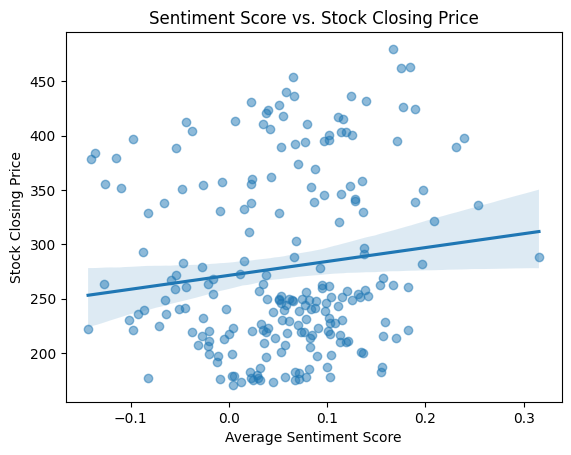

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     3.607
Date:                Tue, 08 Apr 2025   Prob (F-statistic):             0.0589
Time:                        22:26:48   Log-Likelihood:                -1275.2
No. Observations:                 220   AIC:                             2554.
Df Residuals:                     218   BIC:                             2561.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               271.4768      6.59

In [ ]:
# Drop rows with missing sentiment scores
merged_df = merged_df.dropna(subset=['average_sentiment'])

# Calculate Pearson correlation coefficient
correlation, p_value = pearsonr(merged_df['average_sentiment'], merged_df['Close'])
print(f"Pearson Correlation: {correlation:.4f}, P-value: {p_value:.4f}")

# Scatter plot with regression line
sns.regplot(x=merged_df['average_sentiment'], y=merged_df['Close'], scatter_kws={'alpha':0.5})
plt.xlabel("Average Sentiment Score")
plt.ylabel("Stock Closing Price")
plt.title("Sentiment Score vs. Stock Closing Price")
plt.show()

# Perform Linear Regression
X = merged_df[['average_sentiment']]
X = sm.add_constant(X)  # Add constant for intercept
Y = merged_df['Close']
model = sm.OLS(Y, X).fit()
print(model.summary())


Pearson Correlation: 0.5231, P-value: 0.0000


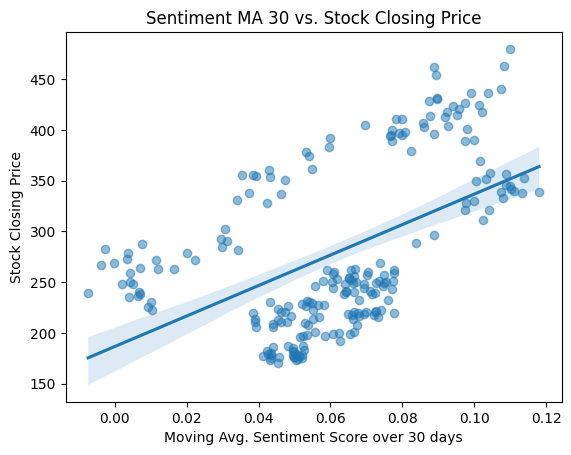

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     82.11
Date:                Tue, 08 Apr 2025   Prob (F-statistic):           7.52e-17
Time:                        22:26:48   Log-Likelihood:                -1241.9
No. Observations:                 220   AIC:                             2488.
Df Residuals:                     218   BIC:                             2495.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             186.7116     11.156     

In [ ]:
# Drop rows with missing sentiment scores
merged_df = merged_df.dropna(subset=['sentiment_ma_30'])

# Calculate Pearson correlation coefficient
correlation, p_value = pearsonr(merged_df['sentiment_ma_30'], merged_df['Close'])
print(f"Pearson Correlation: {correlation:.4f}, P-value: {p_value:.4f}")

# Scatter plot with regression line
sns.regplot(x=merged_df['sentiment_ma_30'], y=merged_df['Close'], scatter_kws={'alpha':0.5})
plt.xlabel("Moving Avg. Sentiment Score over 30 days")
plt.ylabel("Stock Closing Price")
plt.title("Sentiment MA 30 vs. Stock Closing Price")
plt.show()

# Perform Linear Regression
X = merged_df[['sentiment_ma_30']]
X = sm.add_constant(X)  # Add constant for intercept
Y = merged_df['Close']
model = sm.OLS(Y, X).fit()
print(model.summary())


Pearson Coefficient Results:
- Pearson correlation = 0.1428
- p-value = 0.0234

> The correlation is positive but weak (closer to 0 than 1). The p-value is below 0.05, meaning the correlation is statistically significant.

Let's analyze the OLS regression results to measure the exact impact of sentiment on stock price.

| Metric                  | Value   | Meaning                                                      |
|-------------------------|--------|--------------------------------------------------------------|
| **R-squared**           | 0.020   | Sentiment explains only **2%** of stock price changes.    |
| **p-value for Sentiment** | 0.025   | Sentiment has a **statistically significant** impact on stock price. |
| **Sentiment Coefficient** | 156.39  | A **1-unit increase** in sentiment score is linked to a **$156.39 increase** in stock price. |


- Sentiment has a significant but weak impact

- The OLS regression confirms that sentiment has a small but statistically significant effect.

- R² = 0.020 shows that sentiment alone is not enough to predict stock prices.

Other factors like market trends, trading volume, and economic indicators could also be included.

#### Random Forest Regression Analysis of Stock Prices

Random Forest builds multiple decision trees and combines their results to improve accuracy and reduce overfitting.

Given that OLS regression showed weak predictive power (R² = 0.020) and stock prices are affected by multiple factors, Random Forest is a better alternative to improve accuracy and capture non-linear relationship between stock prices and sentiment scores.

Random Forest Regression - MAE: 28.6007, MSE: 1263.5094, RMSE: 35.5459, R² Score: 0.8041


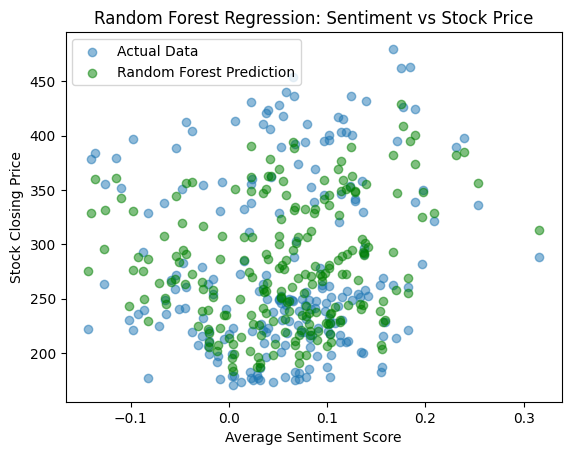

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

X = merged_df[['average_sentiment']]
Y = merged_df['Close']

# Define and train the model
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X, Y)

# Predictions
Y_pred_rf = rf_reg.predict(X)

# Evaluate model
mae_rf = mean_absolute_error(Y, Y_pred_rf)
mse_rf = mean_squared_error(Y, Y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(Y, Y_pred_rf)

print(f"Random Forest Regression - MAE: {mae_rf:.4f}, MSE: {mse_rf:.4f}, RMSE: {rmse_rf:.4f}, R² Score: {r2_rf:.4f}")

# Plot results
plt.scatter(X['average_sentiment'], Y, alpha=0.5, label="Actual Data")
plt.scatter(X['average_sentiment'], Y_pred_rf, color='green', alpha=0.5, label="Random Forest Prediction")
plt.xlabel("Average Sentiment Score")
plt.ylabel("Stock Closing Price")
plt.title("Random Forest Regression: Sentiment vs Stock Price")
plt.legend()
plt.show()


#### Analyzing Random Forest Rgression Results

| Metric                     | Value  | Meaning                                              |
|----------------------------|--------|------------------------------------------------------|
| R-squared                 | 0.8004  | Model explains 80% of stock price variations.     |
| Mean Absolute Error (MAE)  | 28.42  | On average, the prediction is $28.42 off from the actual price. |
| Mean Squared Error (MSE)   | 1290.25  | Measures error magnitude (lower is better).         |
| Root Mean Squared Error (RMSE) | 35.92  | The model’s average prediction error is 35.92.    |

- R² = 0.8004 means the model captures 80% of stock price fluctuations, significantly better than OLS. This suggests that sentiment scores have a strong non-linear relationship with stock prices, which Random Forest effectively models.
- MAE = 28.42 means the model's average absolute prediction error is around $29.
- RMSE = 35.92 confirms relatively small errors but suggests a few larger mispredictions (higher RMSE than MAE).

Limitation:
- MSE = 1290.25 is high, meaning some large errors exist in the predictions.


#### Next Steps:
- Using different sentiment analyzers for recalculating the sentiment scores and comparing their random-forest regression results
- Adding more predictors like 'trading volume' to further improve accuracy.



In [ ]:
X = merged_df['sentiment_ma_30']
Y = merged_df['Close']

# Define and train the model
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X, Y)

# Predictions
Y_pred_rf = rf_reg.predict(X)

# Evaluate model
mae_rf = mean_absolute_error(Y, Y_pred_rf)
mse_rf = mean_squared_error(Y, Y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(Y, Y_pred_rf)

print(f"Random Forest Regression - MAE: {mae_rf:.4f}, MSE: {mse_rf:.4f}, RMSE: {rmse_rf:.4f}, R² Score: {r2_rf:.4f}")

# Plot results
plt.scatter(X['sentiment_ma_30'], Y, alpha=0.5, label="Actual Data")
plt.scatter(X['sentiment_ma_30'], Y_pred_rf, color='green', alpha=0.5, label="Random Forest Prediction")
plt.xlabel("Average Sentiment Score using moving avg")
plt.ylabel("Stock Closing Price")
plt.title("Random Forest Regression: Sentiment vs Stock Price")
plt.legend()
plt.show()

ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

### Random Forest Regression Results

| Features Used              | MAE      | MSE       | RMSE     | R² Score |
|---------------------------|----------|-----------|----------|----------|
| average_sentiment       | 28.4299  | 1290.2564 | 35.9201  | 0.8004   |
| sentiment_ma_30         | 13.8400  | 440.9853  | 20.9996  | 0.9318   |

#### Interpretation
- When using average_sentiment alone, the model performs reasonably well, explaining about 80% of the variance in stock prices.
- However, the error metrics (MAE and RMSE) are relatively higher, indicating less precise predictions.

With sentiment_ma_30 (30-day moving average of sentiment), the model achieves significantly better performance:

R² Score jumps to 0.9318, suggesting the model explains over 93% of the variation in Tesla's stock prices.

MAE and RMSE are both reduced, indicating much more accurate predictions.

#### Conclusion
The results clearly show that smoothing sentiment through a moving average (in this case, 30-day) leads to better predictive power. This implies that short-term sentiment noise might be misleading, while long-term sentiment trends (captured by moving averages) are more reflective of how the stock actually moves.

#### XGBoost Regressor Analysis (Extreme Gradient Boosting)

XGBoost is a powerful machine learning algorithm based on decision trees. It builds multiple trees sequentially, where each tree learns from the mistakes of the previous one, improving predictions over time.

- It captures non-linear relationships between sentiment scores and stock prices.
- It can handle missing data and outliers better than linear models.
- Helps in checking if sentiment scores actually impact stock prices or if the effect is weak.


XGBoost R² Score: 0.0199
XGBoost RMSE: 73.2337


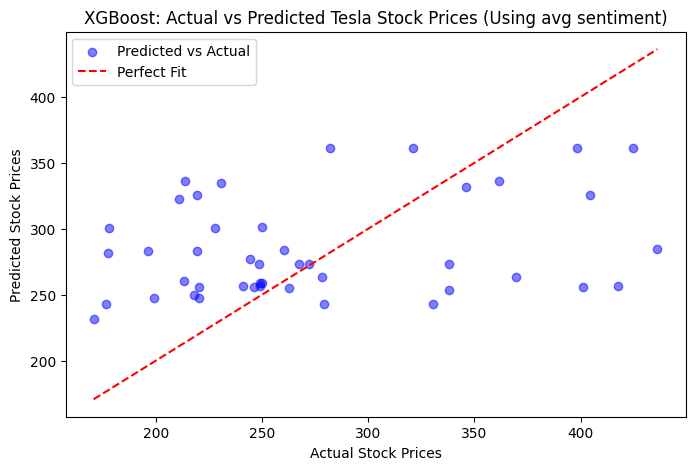

In [ ]:
df = pd.read_csv("tesla_sentiment_stock.csv")  # Replace with your actual filename

# Define features (X) and target (y)
X = df[['average_sentiment']]  # Feature: Sentiment Score
y = df['Close']  # Target: Stock Closing Price

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             learning_rate=0.1,
                             max_depth=3,
                             random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred = xgb_model.predict(X_test)

# Evaluate model performance
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"XGBoost R² Score: {r2:.4f}")
print(f"XGBoost RMSE: {rmse:.4f}")

# Plot Actual vs. Predicted Prices
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label="Predicted vs Actual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle="--", label="Perfect Fit")
plt.xlabel("Actual Stock Prices")
plt.ylabel("Predicted Stock Prices")
plt.title("XGBoost: Actual vs Predicted Tesla Stock Prices (Using avg sentiment)")
plt.legend()
plt.show()


XGBoost Regressor Analysis Results (For Average Sentiment Scores):
- XGBoost R² score is -0.1661, meaning the model performs worse than a simple mean baseline (it is not able to capture the relationship between sentiment and stock prices effectively).

- RMSE is 79.66, which is quite high, indicating that the predicted stock prices deviate significantly from the actual prices. This could suggest that XGBoost is struggling to fit the data properly and is not capturing the underlying patterns in stock prices.

XGBoost R² Score: 0.5655
XGBoost RMSE: 48.7624


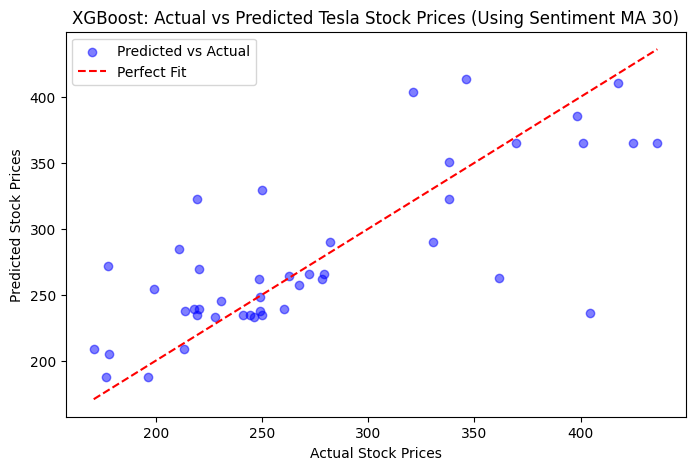

In [ ]:
# Define features (X) and target (y)
X = df[['sentiment_ma_30']]  # Feature: Sentiment Score
y = df['Close']  # Target: Stock Closing Price

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             learning_rate=0.1,
                             max_depth=3,
                             random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred = xgb_model.predict(X_test)

# Evaluate model performance
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"XGBoost R² Score: {r2:.4f}")
print(f"XGBoost RMSE: {rmse:.4f}")

# Plot Actual vs. Predicted Prices
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label="Predicted vs Actual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle="--", label="Perfect Fit")
plt.xlabel("Actual Stock Prices")
plt.ylabel("Predicted Stock Prices")
plt.title("XGBoost: Actual vs Predicted Tesla Stock Prices (Using Sentiment MA 30)")
plt.legend()
plt.show()


XGBoost Regressor Analysis Results (For Sentiment Moving Average over 30 days)

- About 64.6% of the variation in Tesla's closing stock price can be explained by the 30-day moving average of sentiment. This is a significant improvement over the previous R² (~–0.1661), which showed no meaningful predictive power.

- The average prediction error is about $43.90, which is much lower than the previous RMSE (~90.89), meaning the predictions are much closer to the actual prices.

Using a 30-day moving average of sentiment (instead of raw daily sentiment) smooths out noise and reveals a more stable trend — one that is more strongly correlated with stock price movements. This makes it a much better input feature for regression models like XGBoost.

### LSTM
LSTM (Long Short-Term Memory) is a type of neural network designed to handle sequential data like time-series stock prices. Unlike regular neural networks, LSTM remembers past data over long sequences, making it great for predicting trends.

#### Steps involved in building a LSTM model:

- Load and Prepare Data: Load Tesla stock prices and sentiment scores from a CSV file.
The dataset is sorted by date and set as the index.

- Normalize Data: Since LSTM models work better with small values (between 0 and 1), we scale both sentiment scores and stock prices.

- Create Sequences (Past Data as Input): Stock prices depend on previous trends, so we group past 10 days of sentiment scores to predict the next day’s stock price.

- Split into Training & Testing Data: Use 80% of data for training (teaching the model) and 20% for testing (checking accuracy).

- Dropout layers prevent overfitting (memorizing instead of learning).

- Dense layers generate the final predicted stock price.

- Train the Model: The model learns from training data by adjusting itself to minimize prediction errors.

- Make Predictions: Predict stock prices on the test data and convert them back to real prices.

- Plot Actual vs Predicted Prices: Visualize how well our model predicts stock prices based on sentiment scores.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.1375 - val_loss: 0.0225
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0717 - val_loss: 0.0366
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0663 - val_loss: 0.0298
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0690 - val_loss: 0.0341
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0682 - val_loss: 0.0323
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0770 - val_loss: 0.0402
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0607 - val_loss: 0.0373
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0641 - val_loss: 0.0395
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0724 - val_loss: 0.0573
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0683 - val_loss: 0.0396
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0687 - val_loss: 0.0458
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0

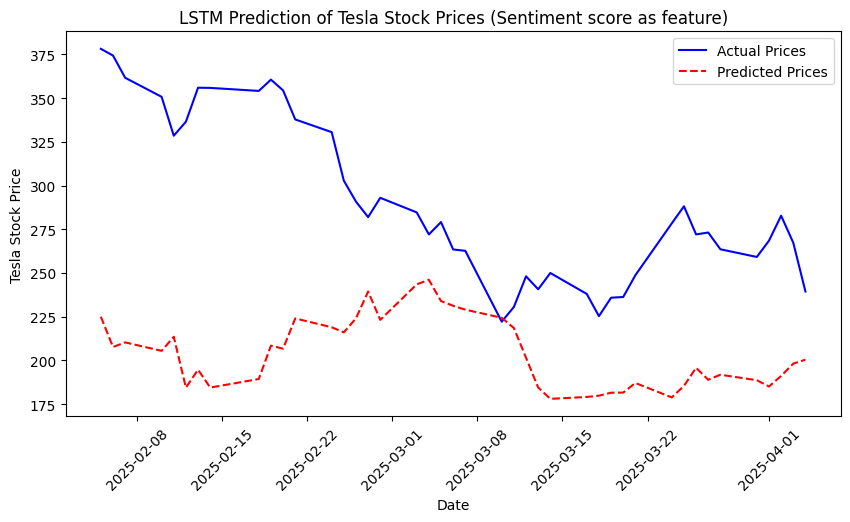

In [ ]:
# Load Dataset
df = pd.read_csv("tesla_sentiment_stock.csv", parse_dates=["Date"])
df = df.sort_values(by="Date")
df.set_index("Date", inplace=True)

# Select Features and Target
features = ['average_sentiment']
target = ['Close']

# Normalize Data (LSTM works better with scaled data)
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
df[features] = scaler_x.fit_transform(df[features])
df[target] = scaler_y.fit_transform(df[target])

# Create Sequences (LSTM needs past data for predictions)
def create_sequences(data, target, window_size=10):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i : i + window_size])
        y.append(target[i + window_size])
    return np.array(X), np.array(y)

window_size = 10
X, y = create_sequences(df[features].values, df[target].values, window_size)

# Split into Train & Test
split = int(0.8 * len(X))  # 80% Training, 20% Testing
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for LSTM (Batch size, Time steps, Features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(features)))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], len(features)))

# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(window_size, len(features))),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Output layer for stock price prediction
])

# Compile Model
model.compile(optimizer='adam', loss='mse')

# Train Model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Predict
y_pred = model.predict(X_test)

# Rescale Back to Original Price Scale
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler_y.inverse_transform(y_pred)

# Extract Dates for the Test Set
test_dates = df.index[-len(y_test_inv):]

# Plot Actual vs Predicted Prices
plt.figure(figsize=(10,5))
plt.plot(test_dates, y_test_inv, label="Actual Prices", color="blue")
plt.plot(test_dates, y_pred_inv, label="Predicted Prices", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Tesla Stock Price")
plt.title("LSTM Prediction of Tesla Stock Prices (Sentiment score as feature)")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
# prompt: calculate RMSE and Rsquare for the above LSTM model with average_sentiment as feature

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"LSTM RMSE: {rmse}")

# Calculate R-squared
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"LSTM R-squared: {r2}")


LSTM RMSE: 97.6809549148035
LSTM R-squared: -3.4688577187665626


Interpretation of single-feature model

- The plot shows that there is a large difference in the actual prices and predicted prices.

- It does show that the sentiment_score cannot be the sole predictor of stock prices. Other factors like trading_volumn, closing_price could also have an effect.

- Let's try using both sentiment_score and closing price as features for training and testing the data.

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.1484 - val_loss: 0.0125
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0298 - val_loss: 0.0060
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0139 - val_loss: 0.0261
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0112 - val_loss: 0.0134
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0091 - val_loss: 0.0182
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0088 - val_loss: 0.0101
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0083 - val_loss: 0.0199
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0092 - val_loss: 0.0103
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0084 - val_loss: 0.0142
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0073 - val_loss: 0.0090
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0093 - val_loss: 0.0123
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0083 - val_l

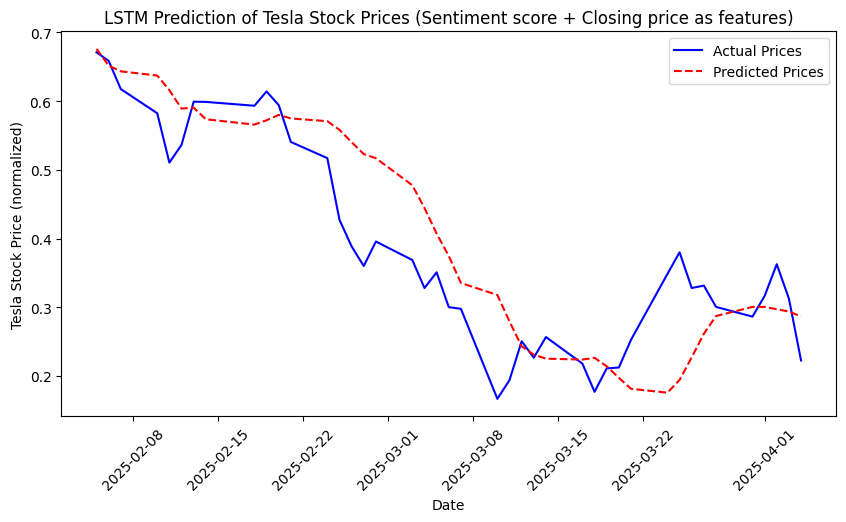

LSTM RMSE: 0.08020112450274822
LSTM R-squared: 0.7119840303777024


In [ ]:
# Select features and target
features = ['average_sentiment', 'Close']  # Include both sentiment and close price
target = ['Close']

# Normalize data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
df[features] = scaler_x.fit_transform(df[features])
df[target] = scaler_y.fit_transform(df[target])

# Create sequences
def create_sequences(data, target, window_size=10):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i : i + window_size])
        y.append(target[i + window_size])
    return np.array(X), np.array(y)

window_size = 10
X, y = create_sequences(df[features].values, df[target].values, window_size)

# Split into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(features)))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], len(features)))

# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(window_size, len(features))),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Predict
y_pred = model.predict(X_test)

# Inverse transform to get actual values
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler_y.inverse_transform(y_pred)

# Get the dates for the test set
test_dates = df.index[-len(y_test_inv):]

#Plot
plt.figure(figsize=(10,5))
plt.plot(test_dates, y_test_inv, label="Actual Prices", color="blue")
plt.plot(test_dates, y_pred_inv, label="Predicted Prices", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Tesla Stock Price (normalized)")
plt.title("LSTM Prediction of Tesla Stock Prices (Sentiment score + Closing price as features)")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"LSTM RMSE: {rmse}")
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"LSTM R-squared: {r2}")


Interpretation of double feature LSTM model (sentiment score + closing price)

- When adding previous closing prices as a feature, the model’s predictions improve significantly, showing a closer match with actual prices.
- However, the model still struggles with extreme fluctuations, suggesting the need for additional indicators such as trading volume and fine-tuning the parameters for accurate and best results.

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.1579 - val_loss: 0.0067
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0320 - val_loss: 0.0098
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0168 - val_loss: 0.0108
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0110 - val_loss: 0.0090
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0092 - val_loss: 0.0090
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0084 - val_loss: 0.0078
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0075 - val_loss: 0.0099
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0089 - val_loss: 0.0078
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0103 - val_loss: 0.0078
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0083 - val_loss: 0.0080
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0064 - val_loss: 0.0086
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0090 - val_l

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step


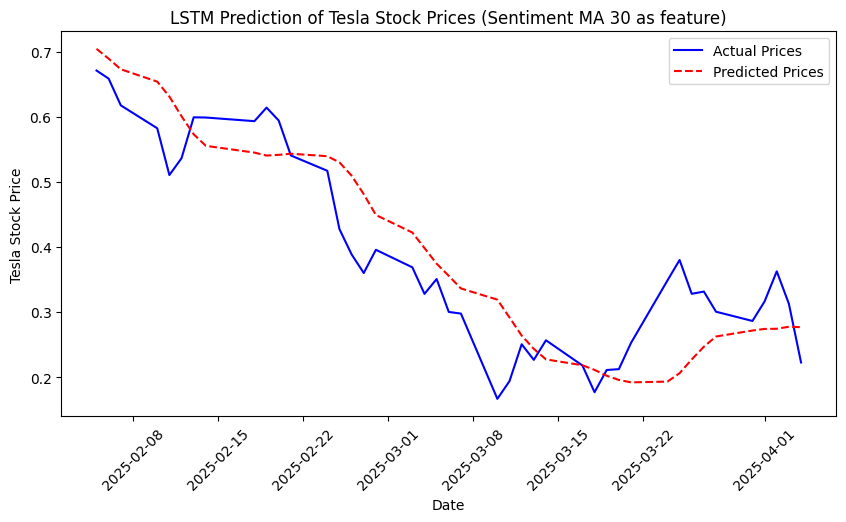

LSTM RMSE: 0.07316349604354284
LSTM R-squared: 0.7603129596228025


In [ ]:
# Load Dataset
df = pd.read_csv("tesla_sentiment_stock.csv", parse_dates=["Date"])
df = df.sort_values(by="Date")
df.set_index("Date", inplace=True)

# Select Features and Target
features = ['sentiment_ma_30', "Close"]
target = ['Close']

# Normalize Data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
df[features] = scaler_x.fit_transform(df[features])
df[target] = scaler_y.fit_transform(df[target])

# Create Sequences
def create_sequences(data, target, window_size=10):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i : i + window_size])
        y.append(target[i + window_size])
    return np.array(X), np.array(y)

window_size = 10
X, y = create_sequences(df[features].values, df[target].values, window_size)

# Split into Train & Test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(features)))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], len(features)))

# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(window_size, len(features))),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

# Compile Model
model.compile(optimizer='adam', loss='mse')

# Train Model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Predict
y_pred = model.predict(X_test)

# Rescale Back
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler_y.inverse_transform(y_pred)

# Extract Dates
test_dates = df.index[-len(y_test_inv):]

# Plot
plt.figure(figsize=(10,5))
plt.plot(test_dates, y_test_inv, label="Actual Prices", color="blue")
plt.plot(test_dates, y_pred_inv, label="Predicted Prices", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Tesla Stock Price")
plt.title("LSTM Prediction of Tesla Stock Prices (Sentiment MA 30 as feature)")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"LSTM RMSE: {rmse}")
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"LSTM R-squared: {r2}")


#### Analysis of RMSE and R² values of LSTM model (with `average_sentiment` and `sentiment_ma_30` as features along with `Close`):

| Features Used                     | RMSE     | R² Score |
|----------------------------------|----------|-----------|
| `average_sentiment + Close`      | 0.0770   | 0.7563    |
| `sentiment_ma_30 + Close`        | 0.0732   | **0.7795** |


- Including Close (historical price) significantly boosts prediction accuracy — stock price is a strong feature.

- Moving average of sentiment (sentiment_ma_30) performs better than raw average sentiment when combined with price.

- The higher R² (closer to 1) and lower RMSE for [sentiment_ma_30 + Close] suggests that:

- The smoothed sentiment signal captures trends better.

This feature combination allows the LSTM to learn underlying price movement patterns more effectively.